### Import Libraries

In [1]:
# Ignore cuDDa warning messages
import warnings
import os
warnings.filterwarnings('ignore')

# Enable GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Expands the Jupyter Notebook Output Size to fit your window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load in tensorboard
%load_ext tensorboard

# Change the working directory back to the original to keep paths the same between files
os.chdir(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND')

import datetime
import pickle
import sys
from os.path import join, isfile
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

from explore_entities import Graph_Entities
import ipywidgets as widgets
from ipywidgets import Layout, GridBox
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
import os
import math

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Allows for scrolling windows to be very large

In [2]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

### Import TF_models and truncate the entities to only contain 880 companies

In [3]:
from tensorflow_models import TF_Models, Ein_Multiply, leaky_relu, rank_loss_func
DMJ = TF_Models('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/', './ignorable_data/models/[55, 25, 20]_split/', reload=False)
data_splits = DMJ.split_data()

DMJ.Normalized_Adjacency_Matrix = DMJ.Normalized_Adjacency_Matrix[0:880, 0:880]
DMJ.XX_tf = DMJ.XX_tf[0:-1, :, :]
DMJ.YY_tf = DMJ.YY_tf[0:-1, :]
DMJ.RR_tf = DMJ.RR_tf[0:-1, :]
DMJ.entities = DMJ.entities[0:-1]
DMJ.entities_idx.pop('ZUMZ')

model = DMJ.generate_model()

from graph_predictions import Graph_Predictions
GP = Graph_Predictions("./ignorable_data/models/[55, 25, 20]_split/", "./ignorable_data/strategies/RL_validation_strategies/", 'x_val', DMJ)

GridBox(children=(Dropdown(description='Model Types:', options=('lstm', 'lstm_gcn_1', 'lstm_gcn_2', 'lstm_gcn_…

In [ ]:
GP.compare_data_blocks('.\ignorable_data\datablocks\[55, 25, 20]_splits')

In [20]:
import matplotlib.pyplot as plt

In [ ]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

# one_x = DMJ.XX_tf[0:2, :, :]
# one_y = DMJ.YY_tf[0:2, :]
one_x = DMJ.XX_tf
print(DMJ.XX_tf.shape)
one_y = DMJ.YY_tf

# one_x = DMJ.XX_tf[0:-1, :, :]
# one_y = DMJ.YY_tf[0:-1, :]

# # Given a dataset, let's section off a fifth of the data to be used for testing purposes
# time_split = [1000, 239,]
# x_train, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
#                                   axis=1)
# y_train, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
#                                   axis=1)
# rr_train, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
#                                      axis=1)

# Given a dataset, let's section off a fifth of the data to be used for testing purposes
time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [40,40,20]
x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

In [6]:
tf.random.set_seed(100998)
optimizer = tf.keras.optimizers.Adam()
from tensorflow_models import rank_loss_correct_pred_return_sequences

# Create a function for the Tensorflow implementation of Tensorflow 2
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

# Load in an already trained LSTM Model############################
file_name = '04-01-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS'
# model_path = '/content/drive/Shareddrives/Max Huffman - ECEN 403 404 URS Research 2020 2021/Datasets/models/after_3_dimensional_RL_change/'
model_path = r"G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\models\after_3_dimensional_RL_change/"
pre_trained_lstm = tf.keras.models.load_model(model_path + f'{file_name}', compile=False,
                                              custom_objects={'leaky_relu': leaky_relu})

In [37]:
def data_gen():
    while True:
        x = np.random.rand(880, 248, 5)  # batch x time x features
        yield x, x[:, :, 0] * x[:, :, 1] < 0.25

def var_importance(model):
    
    def data_gen():
        while True:
            x = np.random.rand(880, 248, 5)  # batch x time x features
            yield x, x[:, :, 0] * x[:, :, 1] < 0.25
    
    g = data_gen()
    x = np.concatenate([next(g)[0] for _ in range(50)]) # Get a sample of data
    orig_out = model.predict(x)
    perturbations = []
    for i in range(5):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        perturbations.append(effect)
    
    return perturbations
        

def main():
    model = pre_trained_lstm
    model.compile(optimizer, rank_loss_correct_pred_return_sequences)
    print(model.summary())
#     model.fit_generator(data_gen(), steps_per_epoch=500, epochs=10)
    var_importance(model)

if __name__ == "__main__":
    main()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 495, 5)]          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 495, 64)           17920     
_________________________________________________________________
dense_10 (Dense)             (None, 495, 1)            65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________
None
Variable 1, perturbation effect: 0.0823
Variable 2, perturbation effect: 0.0238
Variable 3, perturbation effect: 0.0230
Variable 4, perturbation effect: 0.0142
Variable 5, perturbation effect: 0.0324


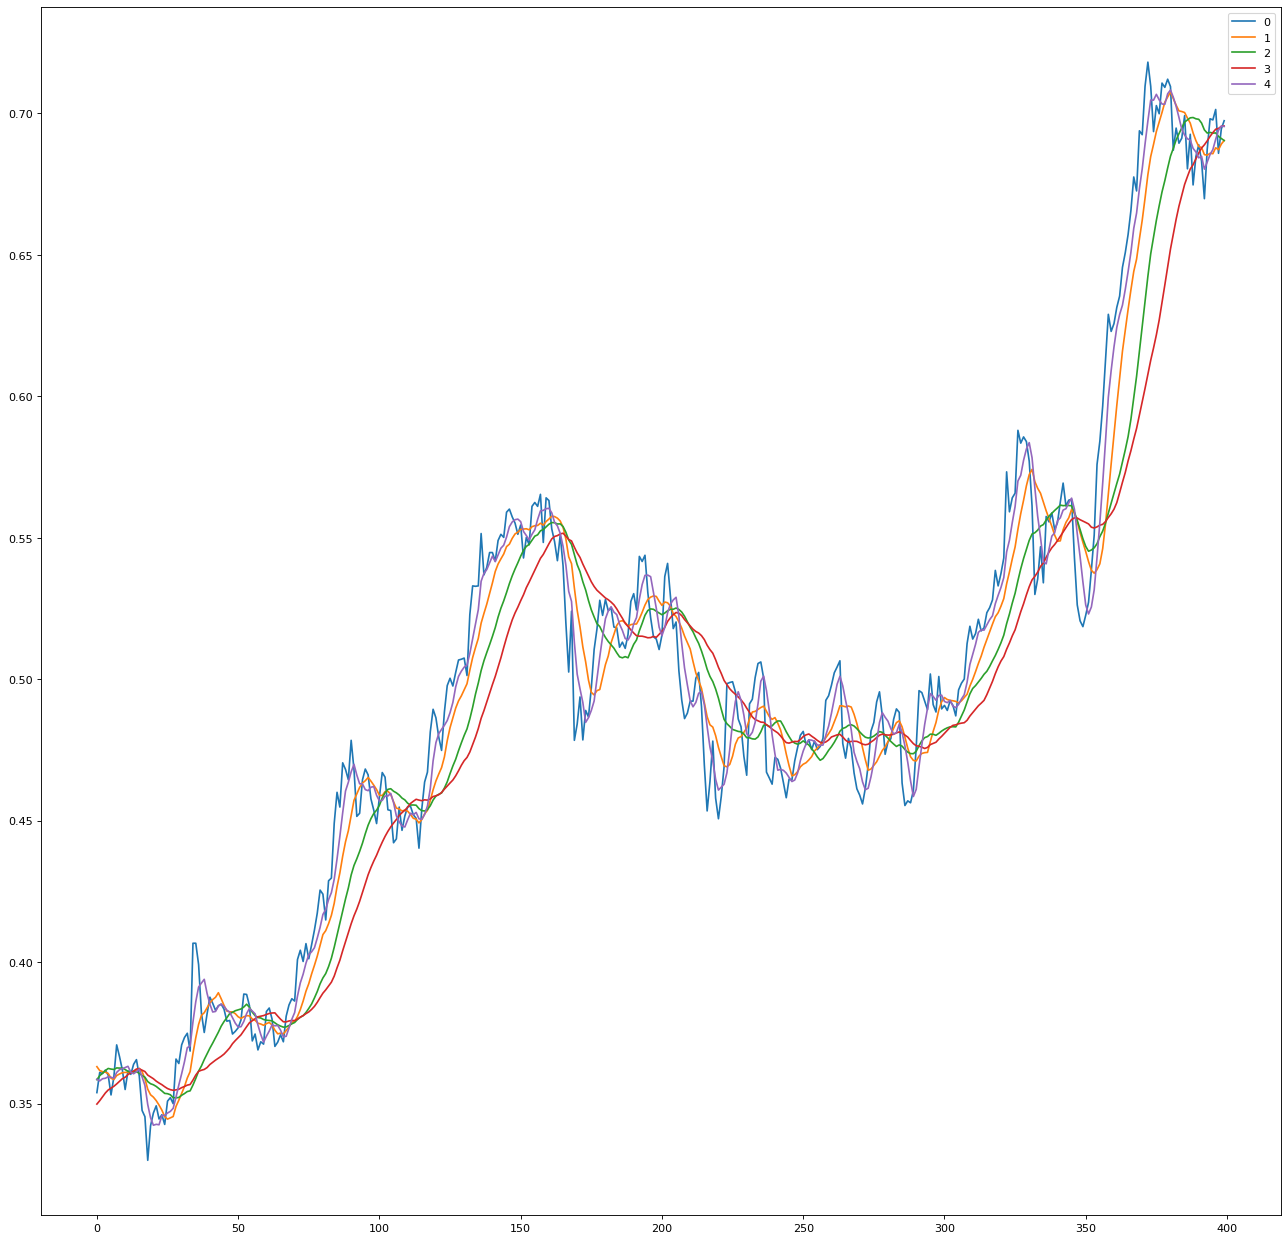

In [33]:
plt.figure(figsize=(20, 20), dpi=80)

DMJ.XX_tf.shape
plt.plot(DMJ.XX_tf[0, 100:500, 0], label='0')
plt.plot(DMJ.XX_tf[0, 100:500, 1],label='1')
plt.plot(DMJ.XX_tf[0, 100:500, 2], label='2')
plt.plot(DMJ.XX_tf[0, 100:500, 3], label='3')
plt.plot(DMJ.XX_tf[0, 100:500, 4], label='4')
plt.legend()

In [1]:
plt.style.use('seaborn')
import matplotlib as mpl

mpl.rcParams['font.size'] = 14

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Closing Price', '5D-MA', '10D-MA', '20D-MA', '30D-MA'
sizes = perturbations
# explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
ax1.pie(sizes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)

plt.show()

NameError: name 'plt' is not defined

In [45]:
def sum(l):
    s = 0
    for i in l:
        s = i + s
    return s

def normalize(l):
    return [i/sum(l) for i in l]

normalize([0.0823, 0.0324, 0.0238, 0.0230, 0.0142])

[0.46841206602162777,
 0.18440523619806487,
 0.1354581673306773,
 0.1309049516220831,
 0.08081957882754696]

In [59]:
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])

In [60]:
arr

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [77]:
np.delete(arr, 2,0)

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

NameError: name 'adj' is not defined